In [1]:
import pandas as pd, numpy as np, os, seaborn as sns, librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/toronto-emotional-speech-set-tess


In [1]:
from torch.utils.data import Dataset

In [2]:
import torch
import torchaudio

### Dataset-> Toronto Emotional Speech dataset

In [34]:
path=f"C:\\Users\\alok4\\Desktop\\Audio-Processing-ML\\Dataset"

In [35]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        paths.append(os.path.join(dirname,filename))
        label=filename.split('_')[-1]
        label=label.split('.')[0]
        labels.append(label.lower())
    if len(paths)==2800:
        break
print('Dataset loaded')


Dataset loaded


In [36]:
len(paths)

2800

In [37]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

In [38]:
df=pd.DataFrame()
df['audio_paths']=paths
df['labels']=labels
df.head()

,audio_paths,labels
0,C:\Users\alok4\Desktop\Audio-Processing-ML\Dat...,angry
1,C:\Users\alok4\Desktop\Audio-Processing-ML\Dat...,angry
2,C:\Users\alok4\Desktop\Audio-Processing-ML\Dat...,angry
3,C:\Users\alok4\Desktop\Audio-Processing-ML\Dat...,angry
4,C:\Users\alok4\Desktop\Audio-Processing-ML\Dat...,angry


In [39]:
df['labels'].value_counts()

labels
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

## Exploratory Data Analysis

<Axes: xlabel='labels', ylabel='count'>

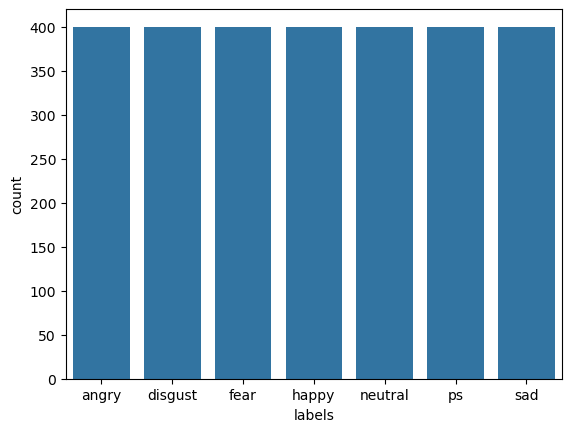

In [40]:
sns.countplot(data=df,x='labels')

In [41]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()

def spectrogram(data,sr,emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion,size=20)
    librosa.display.specshow(xdb,sr=sr,x_axis="time",y_axis="hz")
    plt.colorbar()

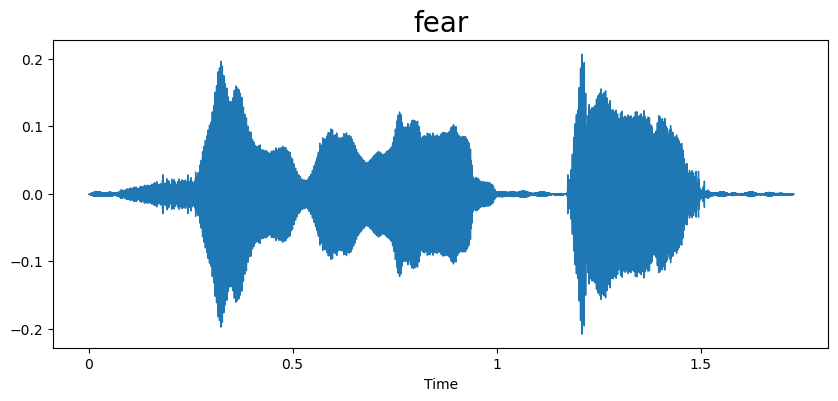

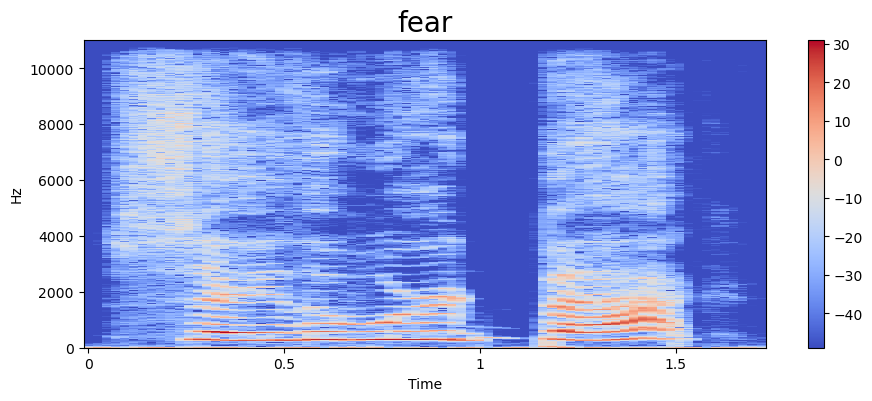

In [42]:
emotion="fear"
path=np.array(df['audio_paths'][df['labels']==emotion])[0]
data,sampling_rate=librosa.load(path)
waveplot(data,sampling_rate,emotion=emotion)
spectrogram(data=data,sr=sampling_rate,emotion=emotion)
Audio(path)

Create a custom dataset class

In [43]:
# convert labels to integers
label_map={label:idx for idx, label in enumerate(df['labels'].unique())}

In [44]:
inverse_label_map={idx:label for idx, label in label_map.items()}
df['labels']=df['labels'].map(label_map)
df['labels']
df.head(2)

,audio_paths,labels
0,C:\Users\alok4\Desktop\Audio-Processing-ML\Dat...,0
1,C:\Users\alok4\Desktop\Audio-Processing-ML\Dat...,0


In [5]:
class SpeechEmotionDataset(Dataset):
    def __init__(self,df,processor,max_len=44100):
        self.df=df
        self.processor=processor
        self.max_len=max_len
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        audio_path=self.df.iloc[index]['audio']
        label=self.df.iloc[index]['label']
        # load the audio file
        speech, _ =torchaudio.load(audio_path)
        speech=speech.squeeze().numpy()
        # pad or truncate the speech to the required length

        if len(speech)>self.max_len:
            speech=speech[:self.max_len]
        else:
            speech=np.pad(speech,(0,self.max_len-len(speech)),'constant')

        inputs=self.processor(speech,sampling_rate=22050)